In our project titled "Exploring Diverse Embeddings for Movie Recommendations," we delve into optimizing movie recommendation systems using the 'AIatMongoDB/embedded_movies' dataset from Hugging Face. We begin by cleansing the data and conducting exploratory data analysis to unveil prevalent cinematic genres and attribute correlations. Subsequently, we compare the effectiveness of three embedding methodologies—TF-IDF Vectorizer, Count Vectorizer, and OpenAI Text-Embedding-Ada-002—in generating personalized movie recommendations. Through empirical evaluation, our study aims to advance data-driven cinematic exploration by identifying the most effective embedding approach.

# Library Installation:

The implementation code utilizes the following tools and libraries:

**datasets:** This library, part of the Hugging Face ecosystem, grants access to pre-processed datasets crucial for training and fine-tuning machine learning models or evaluating their performance.

**pandas:** A data science library offering robust data structures and methods for efficient data manipulation, processing, and analysis.

In [34]:
pip install datasets openai

# Data Loading

Retrieve the dataset named "AIatMongoDB/embedded_movies". This dataset comprises various movie attributes such as title, release year, cast, plot, and more. Notably, each movie entry includes a unique plot_embedding field generated using OpenAI's text-embedding-ada-002 model.

In [35]:
from datasets import load_dataset
import pandas as pd

# https://huggingface.co/datasets/AIatMongoDB/embedded_movies

dataset = load_dataset("AIatMongoDB/embedded_movies")

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset['train'])

dataset_df.head(5)

,directors,title,plot,languages,plot_embedding,countries,poster,metacritic,genres,writers,num_mflix_comments,imdb,rated,cast,awards,fullplot,type,runtime
0,"[Louis J. Gasnier, Donald MacKenzie]",The Perils of Pauline,Young Pauline is left a lot of money when her ...,[English],"[0.00072939653, -0.026834568, 0.013515796, -0....",[USA],https://m.media-amazon.com/images/M/MV5BMzgxOD...,NaN,[Action],"[Charles W. Goddard (screenplay), Basil Dickey...",0,"{'id': 4465, 'rating': 7.6, 'votes': 744}",None,"[Pearl White, Crane Wilbur, Paul Panzer, Edwar...","{'nominations': 0, 'text': '1 win.', 'wins': 1}",Young Pauline is left a lot of money when her ...,movie,199.0
1,"[Alfred J. Goulding, Hal Roach]",From Hand to Mouth,A penniless young man tries to save an heiress...,[English],"[-0.022837115, -0.022941574, 0.014937485, -0.0...",[USA],https://m.media-amazon.com/images/M/MV5BNzE1OW...,NaN,"[Comedy, Short, Action]",[H.M. Walker (titles)],0,"{'id': 10146, 'rating': 7.0, 'votes': 639}",TV-G,"[Harold Lloyd, Mildred Davis, 'Snub' Pollard, ...","{'nominations': 1, 'text': '1 nomination.', 'w...",As a penniless man worries about how he will m...,movie,22.0
2,[Herbert Brenon],Beau Geste,"Michael ""Beau"" Geste leaves England in disgrac...",[English],"[0.00023330493, -0.028511643, 0.014653289, -0....",[USA],None,NaN,"[Action, Adventure, Drama]","[Herbert Brenon (adaptation), John Russell (ad...",0,"{'id': 16634, 'rating': 6.9, 'votes': 222}",None,"[Ronald Colman, Neil Hamilton, Ralph Forbes, A...","{'nominations': 0, 'text': '1 win.', 'wins': 1}","Michael ""Beau"" Geste leaves England in disgrac...",movie,101.0
3,[Albert Parker],The Black Pirate,"Seeking revenge, an athletic young man joins t...",None,"[-0.005927917, -0.033394486, 0.0015323418, -0....",[USA],https://m.media-amazon.com/images/M/MV5BMzU0ND...,NaN,"[Adventure, Action]","[Douglas Fairbanks (story), Jack Cunningham (a...",1,"{'id': 16654, 'rating': 7.2, 'votes': 1146}",None,"[Billie Dove, Tempe Pigott, Donald Crisp, Sam ...","{'nominations': 0, 'text': '1 win.', 'wins': 1}",A nobleman vows to avenge the death of his fat...,movie,88.0
4,[Sam Taylor],For Heaven's Sake,An irresponsible young millionaire changes his...,[English],"[-0.0059373598, -0.026604708, -0.0070914757, -...",[USA],https://m.media-amazon.com/images/M/MV5BMTcxMT...,NaN,"[Action, Comedy, Romance]","[Ted Wilde (story), John Grey (story), Clyde B...",0,"{'id': 16895, 'rating': 7.6, 'votes': 918}",PASSED,"[Harold Lloyd, Jobyna Ralston, Noah Young, Jim...","{'nominations': 1, 'text': '1 nomination.', 'w...","The Uptown Boy, J. Harold Manners (Lloyd) is a...",movie,58.0


# Data Preprocessing

The dataset has been successfully loaded. Next, let's inspect for any missing values within the dataset. Upon examination, it appears that there are some null values present in our dataframe. To address this, we'll proceed by removing the missing values, especially for columns "plot" and "plot_embedding", which will be used for our embedding models.

In [36]:
null_values = dataset_df.isnull().sum()

#--- Inspect data ---
null_values

directors              13
title                   0
plot                   27
languages               1
plot_embedding         28
countries               0
poster                 89
metacritic            928
genres                  0
writers                13
num_mflix_comments      0
imdb                    0
rated                 308
cast                    1
awards                  0
fullplot               48
type                    0
runtime                15
dtype: int64

In [43]:
# Remove data point where either plot or plot_embedding coloumn is missing
dataset_df = dataset_df.dropna(subset=['plot_embedding'])
dataset_df = dataset_df.dropna(subset=['plot'])

# Exploratory Data Analysis

After preprocessing the dataset to remove null values, we embark on exploratory data analysis to extract insights. Our focus shifts to visualizing film genres via word clouds, translating data into artistic renditions. Each word cloud depicts genre frequency, providing insights into audience preferences and encapsulating each genre's essence.

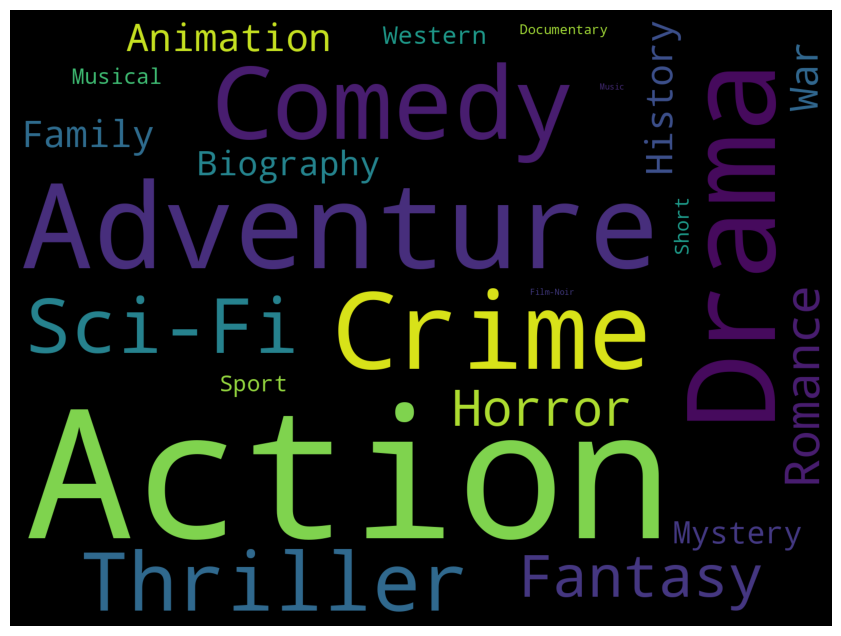

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as wc

series = dataset_df.genres
word_cloud = wc.WordCloud(background_color="black", margin=20, width=800,
                          height=600, prefer_horizontal=0.7, max_words=50, scale=2)

total_genres = []
for i in range(series.size):
    total_genres.extend(series.iloc[i])

unique_genres = list(set(total_genres))

values3 = []
for genre in unique_genres:
    values3.append((genre, total_genres.count(genre)))

values3 = sorted(values3, key=lambda item: item[1], reverse=True)

dictionary = {}
for item in values3:
    dictionary[item[0]] = item[1]

word_cloud.generate_from_frequencies(dictionary)
plt.subplots(figsize=(16, 8))
plt.axis('off')
plt.imshow(word_cloud)
plt.show()

Upon inspecting each column's values, it becomes evident that the "imdb" column holds significant numerical data in JSON format. Our objective is to extract these numerical values from the JSON content within the "imdb" column and establish separate columns titled "rating" and "votes" to encapsulate this valuable data.

In [60]:
import json

def extract_key(json_obj, key):
    try:
        return json_obj[key]
    except KeyError:
        return None

# Extract 'key1' from 'json_column' into a new column 'new_column'
dataset_df['rating'] = dataset_df['imdb'].apply(lambda x: extract_key(x, 'rating'))
dataset_df['votes'] = dataset_df['imdb'].apply(lambda x: extract_key(x, 'votes'))

# Display the DataFrame
dataset_df.head(2)

<ipython-input-60-a2806caa962e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['rating'] = dataset_df['imdb'].apply(lambda x: extract_key(x, 'rating'))
<ipython-input-60-a2806caa962e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['votes'] = dataset_df['imdb'].apply(lambda x: extract_key(x, 'votes'))


,directors,title,plot,languages,plot_embedding,countries,poster,metacritic,genres,writers,...,imdb,rated,cast,awards,fullplot,type,runtime,similarity_score,rating,votes
0,"[Louis J. Gasnier, Donald MacKenzie]",The Perils of Pauline,Young Pauline is left a lot of money when her ...,[English],"[0.00072939653, -0.026834568, 0.013515796, -0....",[USA],https://m.media-amazon.com/images/M/MV5BMzgxOD...,NaN,[Action],"[Charles W. Goddard (screenplay), Basil Dickey...",...,"{'id': 4465, 'rating': 7.6, 'votes': 744}",None,"[Pearl White, Crane Wilbur, Paul Panzer, Edwar...","{'nominations': 0, 'text': '1 win.', 'wins': 1}",Young Pauline is left a lot of money when her ...,movie,199.0,0.722597,7.6,744
1,"[Alfred J. Goulding, Hal Roach]",From Hand to Mouth,A penniless young man tries to save an heiress...,[English],"[-0.022837115, -0.022941574, 0.014937485, -0.0...",[USA],https://m.media-amazon.com/images/M/MV5BNzE1OW...,NaN,"[Comedy, Short, Action]",[H.M. Walker (titles)],...,"{'id': 10146, 'rating': 7.0, 'votes': 639}",TV-G,"[Harold Lloyd, Mildred Davis, 'Snub' Pollard, ...","{'nominations': 1, 'text': '1 nomination.', 'w...",As a penniless man worries about how he will m...,movie,22.0,0.756835,7.0,639


While delving into the quantitative dimensions of cinema, we scrutinized pivotal numerical columns such as 'runtime,' 'votes,' and 'rating' to uncover their interrelations. This exploration yielded an enlightening correlation matrix, depicted visually through a heatmap. Upon analyzing the heatmap, it becomes apparent that runtime, votes, and rating exhibit positive correlations, albeit with moderate degrees.

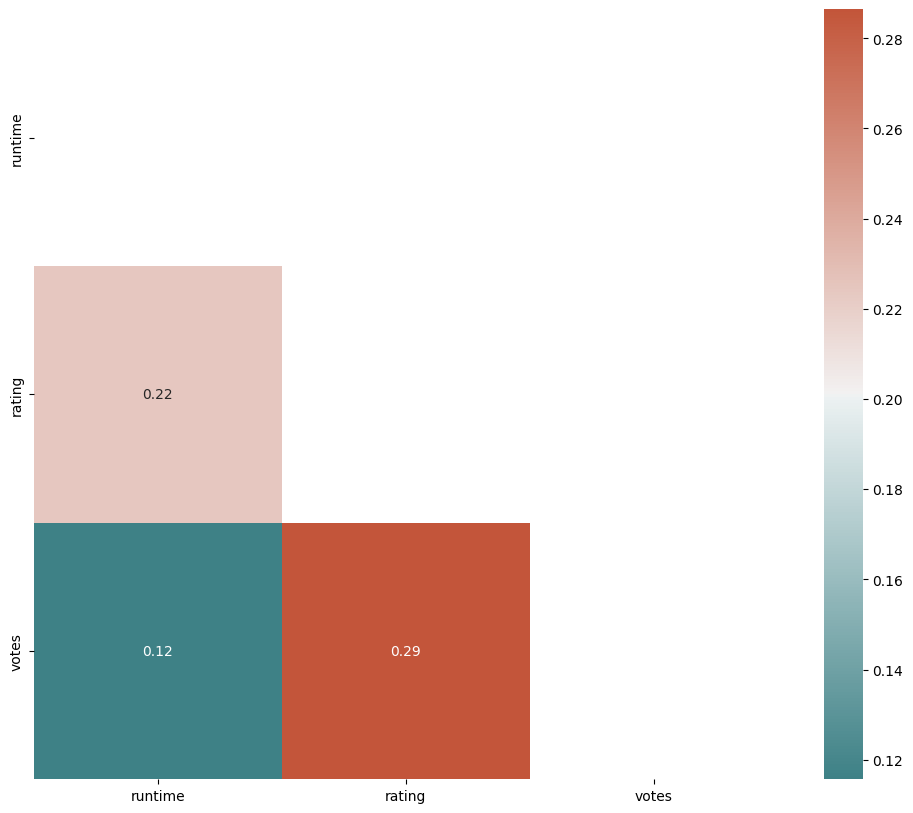

In [61]:
numeric_columns = dataset_df[['runtime', 'rating', 'votes']]
# Calculate the correlation matrix
cor = numeric_columns.corr()
plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(cor, dtype=bool))
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(cor, annot=True, mask=mask, cmap=cmap)
plt.show()

# Embedding Models Comparison

Continuing our journey, we employed three distinct embedding models—TfidfVectorizer, CountVectorizer, and OpenAI Text-Embedding-Ada-002 —to construct a recommendation system and assess their respective performances.



*   **Tfidf Vectorizer**

TF-IDF stands for Term Frequency-Inverse Document Frequency.
It transforms text documents into numerical vectors, where each vector represents a document and the values represent the importance of each word in the document.
It is useful for tasks such as text classification, clustering, and information retrieval.
TF-IDF considers both the frequency of a term in a document and the frequency of the term across all documents, giving higher weights to terms that are rare in the corpus but common in the document.


Leveraging TfidfVectorizer and cosine similarity, we transformed movie descriptions into a comparable matrix.

Upon inputting a selected movie title, the code adeptly identified similar films based on their plot. This personalized list of recommendations empowered movie enthusiasts to explore new cinematic treasures, enhancing their viewing experiences.

In [51]:
indices = pd.Series(dataset_df.index, index=dataset_df['title']).drop_duplicates()

In [53]:
# Write the movie name from the dataset inside the 'title' variable within apostrophes.
title = 'From Hand to Mouth'

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(dataset_df['plot'])
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)
idx = indices[title]
sim_scores = list(enumerate(cosine_sim_tfidf[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:6]
movie_indices = [i[0] for i in sim_scores]
recommend_tfidf = dataset_df['title'].iloc[movie_indices]
recommend_tfidf

716                             Beverly Hills Ninja
804                                      Titan A.E.
1358    The Adventures of Sharkboy and Lavagirl 3-D
1161                                       Cellular
1075                                      Devasuram
Name: title, dtype: object

In [71]:
result_df = recommend_tfidf.to_frame(name='tfidf recommendations').reset_index(drop=True)
result_df

,tfidf recommendations
0,Beverly Hills Ninja
1,Titan A.E.
2,The Adventures of Sharkboy and Lavagirl 3-D
3,Cellular
4,Devasuram




*   **CountVectorizer**

Count Vectorizer converts text documents into a matrix of token counts. It counts the frequency of each word in the document and represents it as a vector. Unlike TF-IDF, it does not consider the importance of words based on their frequency across all documents. Count Vectorizer is simpler and faster compared to TF-IDF Vectorizer but may not capture the importance of rare words effectively.

Similar to TfIdfvectorizer, utilizing CountVectorizer and cosine similarity, we converted movie descriptions into a matrix for comparison. By entering a chosen movie title, the code efficiently identified similar films based on their plots, offering personalized recommendations for movie enthusiasts to discover new cinematic gems.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(dataset_df['plot'])
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
idx = indices[title]
sim_scores = list(enumerate(cosine_sim_count[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:6]
movie_indices = [i[0] for i in sim_scores]
recommend_count = dataset_df['title'].iloc[movie_indices]
recommend_count

716                                   Beverly Hills Ninja
1358          The Adventures of Sharkboy and Lavagirl 3-D
113                                The Chinese Connection
804                                            Titan A.E.
189     Uno sceriffo extraterrestre... poco extra e mo...
Name: title, dtype: object

In [73]:
result_df['count recommendations'] = recommend_count.to_frame().reset_index(drop=True)
result_df

,tfidf recommendations,count recommendations
0,Beverly Hills Ninja,Beverly Hills Ninja
1,Titan A.E.,The Adventures of Sharkboy and Lavagirl 3-D
2,The Adventures of Sharkboy and Lavagirl 3-D,The Chinese Connection
3,Cellular,Titan A.E.
4,Devasuram,Uno sceriffo extraterrestre... poco extra e mo...




*  **Text-Embedding-Ada-002**


Text-Embedding-Ada-002 is an embedding model provided by OpenAI, designed to convert text into dense vector representations.
It captures semantic relationships between words and phrases, allowing for more nuanced understanding of text.
Unlike TF-IDF and Count Vectorizer, which represent words as sparse vectors, text embeddings are dense vectors with continuous values.
Text embeddings are often used in tasks such as text classification, sentiment analysis, and machine translation.


The function "get_embedding(text)" validates the input text, calls the OpenAI API to generate embeddings using the specified model, and returns the resulting embedding.








In [45]:
import openai

# Read API key
openai.api_key = "YOUR-API-KEY"
EMBEDDING_MODEL = "text-embedding-ada-002"

def get_embedding(text):
    """Generate an embedding for the given text using OpenAI's API."""

    # Check for valid input
    if not text or not isinstance(text, str):
        return None

    try:
        # Call OpenAI API to get the embedding
        embedding = openai.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding
        return embedding
    except Exception as e:
        print(f"Error in get_embedding: {e}")
        return None


The function "vector_search(query_embedding, df)" calculates cosine similarity between the query embedding and plot embeddings in DataFrame df, adds a new column for similarity scores, sorts the DataFrame by similarity score, and returns the sorted DataFrame.

In [46]:
import numpy as np

# Function to perform vector search based on embeddings
def vector_search(query_embedding, df):
    # Calculate cosine similarity between query embedding and all plot embeddings
    df['similarity_score'] = df['plot_embedding'].apply(lambda emb: np.dot(query_embedding, emb) / (np.linalg.norm(query_embedding) * np.linalg.norm(emb)))
    # Sort dataframe by similarity score in descending order
    df = df.sort_values(by='similarity_score', ascending=False)
    return df


The function "handle_user_query(query, df)" generates an embedding for the user query, performs vector search, extracts the top 5 matches, formats the search result, utilizes OpenAI's chat completions to generate a response based on the user query and search results, and returns the response and formatted search result.

In [76]:
import openai

# Function to handle user query
def handle_user_query(query, df):
    query_embedding = get_embedding(query)
    if query_embedding is None:
        return "Invalid query or embedding generation failed.", None

    # Perform vector search
    result_df = vector_search(query_embedding, df)
    # Extract top 5 matches
    top_matches = result_df.head(5)
    # Format search result
    search_result = "\n".join([f"Title: {row['title']}, Plot: {row['plot']}" for _, row in top_matches.iterrows()])

    # Use OpenAI chat completions to generate response
    completion = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a movie recommendation system."},
            {"role": "user", "content": "Answer this user query: " + query + " with the following context: " + search_result}
        ]
    )

    return (completion.choices[0].message.content), search_result, top_matches

In [77]:
query = "Any movies similar to From Hand to Mouth?"
response, source_information, top_matches = handle_user_query(query, dataset_df)

print(f"Response: {response}")
print(source_information)


Response: If you enjoyed "From Hand to Mouth", you may like "Grindhouse" for its homage to drive-in double features and cult films. Another recommendation could be "Jesus Christ Vampire Hunter" for its unique blend of genres including action, comedy, horror, and musical elements. These movies offer a similar mix of entertainment and unconventional storytelling that you might enjoy.
Title: Grindhouse, Plot: Quentin Tarantino and Rober Rodriguez's homage to drive-in double features in the 60s and 70s with two back-to-back cult films that include previews of coming attractions between them.
Title: Wheels on Meals, Plot: Cousins Thomas and David, owners of a mobile restaurant, team up with their friend Moby, a bumbling private detective, to save the beautiful Sylvia, a pickpocket. Action and humor abound in...
Title: Jesus Christ Vampire Hunter, Plot: Kung-Fu Action / Comedy / Horror / Musical about the second coming.
Title: Biteu, Plot: This movie follows the story of three friends in Kor

In [88]:
result_df['openai recommendations']=top_matches['title'].reset_index(drop=True)
result_df

,tfidf recommendations,count recommendations,openai recommendations
0,Beverly Hills Ninja,Beverly Hills Ninja,Grindhouse
1,Titan A.E.,The Adventures of Sharkboy and Lavagirl 3-D,Wheels on Meals
2,The Adventures of Sharkboy and Lavagirl 3-D,The Chinese Connection,Jesus Christ Vampire Hunter
3,Cellular,Titan A.E.,Biteu
4,Devasuram,Uno sceriffo extraterrestre... poco extra e mo...,The Rundown


**Interpreting the differences:**

Similar recommendations from TF-IDF Vectorizer and CountVectorizer suggest that
movies with similar textual descriptions or features based on word frequency are recommended.

Different recommendations from OpenAI's Text-Embedding-Ada-002 suggest that movies are recommended based on their semantic meaning and contextual relationships, providing a more nuanced and potentially diverse set of recommendations.


# Summary
TF-IDF Vectorizer, Count Vectorizer, and Text-Embedding-Ada-002 are all techniques used in natural language processing, but they serve different purposes and have different strengths. TF-IDF Vectorizer and Count Vectorizer are traditional methods for converting text into numerical representations, whereas Text-Embedding-Ada-002 is a more advanced technique that captures semantic meaning. For movie recommendation, especially when considering the semantic meaning of movie descriptions and features, using text embedding models like Text-Embedding-Ada-002 would be more suitable. Text embeddings capture the semantic relationships between words and phrases, allowing for a more nuanced understanding of movie plots and descriptions. This can lead to more accurate and personalized movie recommendations based on the similarity of movie descriptions.